# Transforming Non-Stationary IPL Time Series Data to Stationary Data


### 1.Data Generation Process

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

In [4]:
# Normalize the runs for better performance
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [5]:
df=pd.read_csv('all_season_details.csv')

C:\Users\harik\AppData\Local\Temp\ipykernel_11248\2416424084.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('all_season_details.csv')


In [6]:
virat_df = df[df['batsman1_name'] == 'Virat Kohli']

In [7]:
virat_season_runs = virat_df.groupby('season')['runs'].sum()

In [8]:
if isinstance(virat_season_runs, pd.Series):
    virat_season_runs = virat_season_runs.reset_index()

In [9]:
virat_season_runs['season'] = pd.to_datetime(virat_season_runs['season'], format='%Y')
print(virat_season_runs)

       season  runs
0  2008-01-01   187
1  2009-01-01   258
2  2010-01-01   316
3  2011-01-01   584
4  2012-01-01   375
5  2013-01-01   655
6  2014-01-01   373
7  2015-01-01   519
8  2016-01-01   998
9  2017-01-01   314
10 2018-01-01   539
11 2019-01-01   472
12 2020-01-01   477
13 2021-01-01   423
14 2022-01-01   362
15 2023-01-01   661


### 2.Visualizing the Data


####  Plotting the Time Series

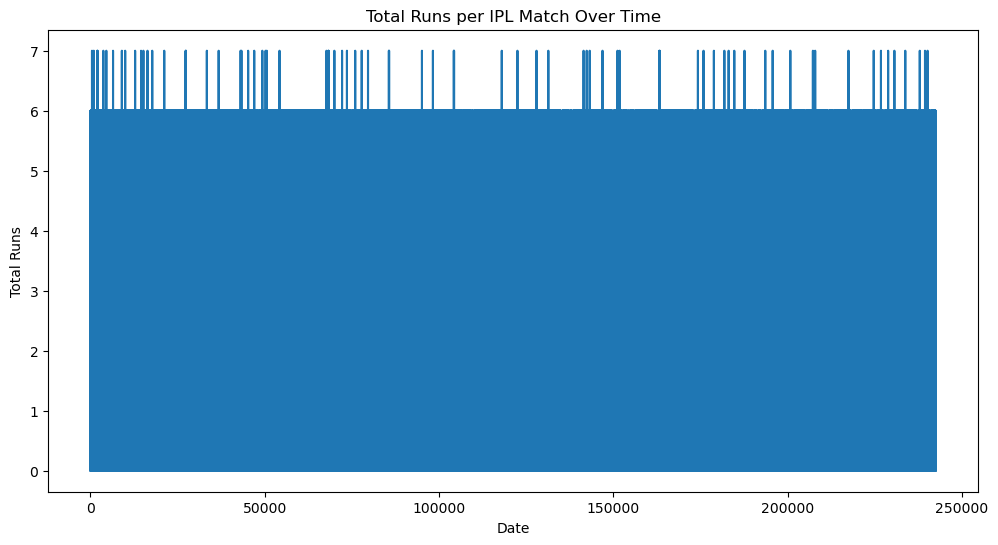

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(df['runs'])
plt.title('Total Runs per IPL Match Over Time')
plt.xlabel('Date')
plt.ylabel('Total Runs')
plt.show()

It helps identify scoring trends, high/low-scoring matches, and possible seasonal patterns in IPL matches.
The plot shows an upward trend with seasonal fluctuations, indicating non-stationarity.

#### Histogram and Density Plot


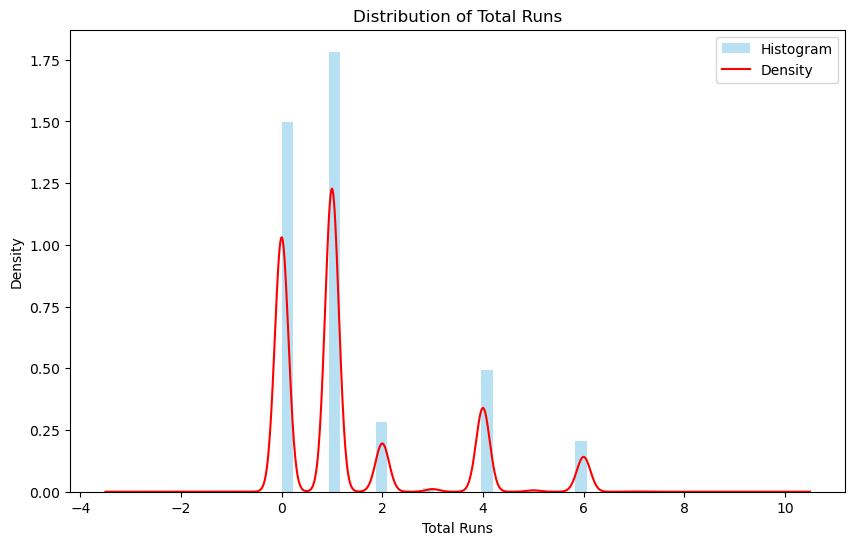

In [15]:
plt.figure(figsize=(10, 6))
df['runs'].plot(kind='hist', bins=30, density=True, alpha=0.6, color='skyblue', label='Histogram')
df['runs'].plot(kind='kde', color='red', label='Density')
plt.title('Distribution of Total Runs')
plt.xlabel('Total Runs')
plt.legend()
plt.show()

the distribution of total runs scored in IPL matches is skewed with most matches having lower total run values, and there are a few matches with higher total runs. 

## 3. Preprocessing the Data

#### Handling Missing Values.

Since we generated the data, there are no missing values. In real datasets, you would check for and handle missing data appropriately.

#### Outlier Detection

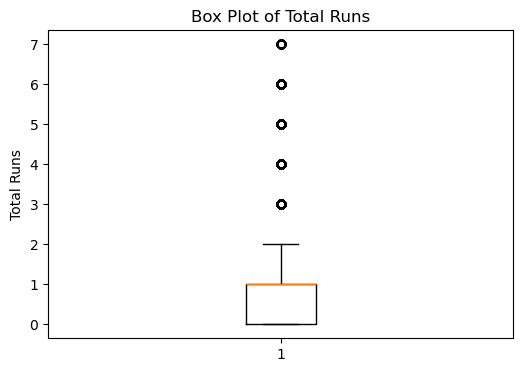

In [21]:
plt.figure(figsize=(6, 4))
plt.boxplot(df['runs'])
plt.title('Box Plot of Total Runs')
plt.ylabel('Total Runs')
plt.show()

Here the Boxplot shows that there is No significant outliers are present.

### Feature Engineering


#### Lag Features


In [25]:
df['Lag_1'] = df['runs'].shift(1)
df['Lag_2'] = df['runs'].shift(2)

#### Time-based Features

In [27]:
df.index = pd.to_datetime(df.index)

In [28]:
df['Month'] = df.index.month
df['Year'] = df.index.year

## 4. Stationarity Check

### Autocorrelation and Partial Autocorrelation Plots

#### Autocorrelation Function (ACF) Plot

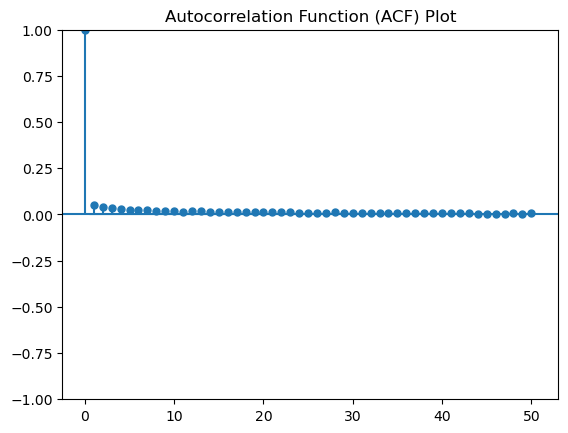

In [32]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['runs'].dropna(), lags=50)
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()

##### ACF Plot: Slow decay indicates non-stationarity.

#### Partial Autocorrelation Function (PACF) Plot

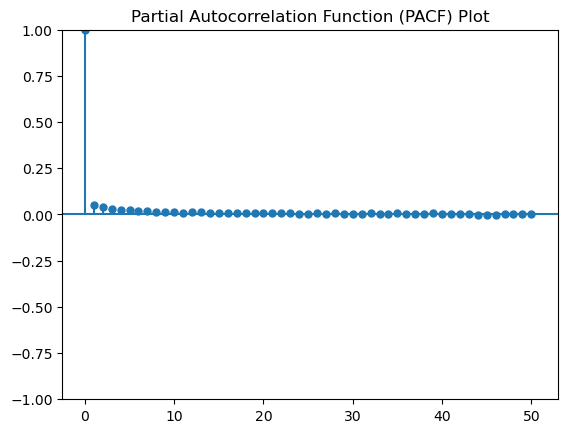

In [35]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['runs'].dropna(), lags=50)
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.show()

##### PACF Plot: Significant lags suggest autoregressive components.


### Augmented Dickey-Fuller (ADF) Test

In [38]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['runs'].dropna())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -64.687619
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


#### Interpretation:##### Null Hypothesis (H0): The series is non-stationary
##### If p-value > 0.05, fail to reject H0; the series is non-stationary.

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

In [44]:
from statsmodels.tsa.stattools import kpss
kpss_result = kpss(df['runs'].dropna(), regression='c')
print('KPSS Statistic: %f' % kpss_result[0])
print('p-value: %f' % kpss_result[1])
print('Critical Values:')
for key, value in kpss_result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 7.479512
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\Users\harik\AppData\Local\Temp\ipykernel_11248\3747156587.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df['runs'].dropna(), regression='c')


#### Interpretation:
##### Null Hypothesis (H0): The series is non-stationary
##### If p-value > 0.05, fail to reject H0; the series is non-stationary.

## 5. Making the Data Stationary

### Differencing

#### First Order Differencing

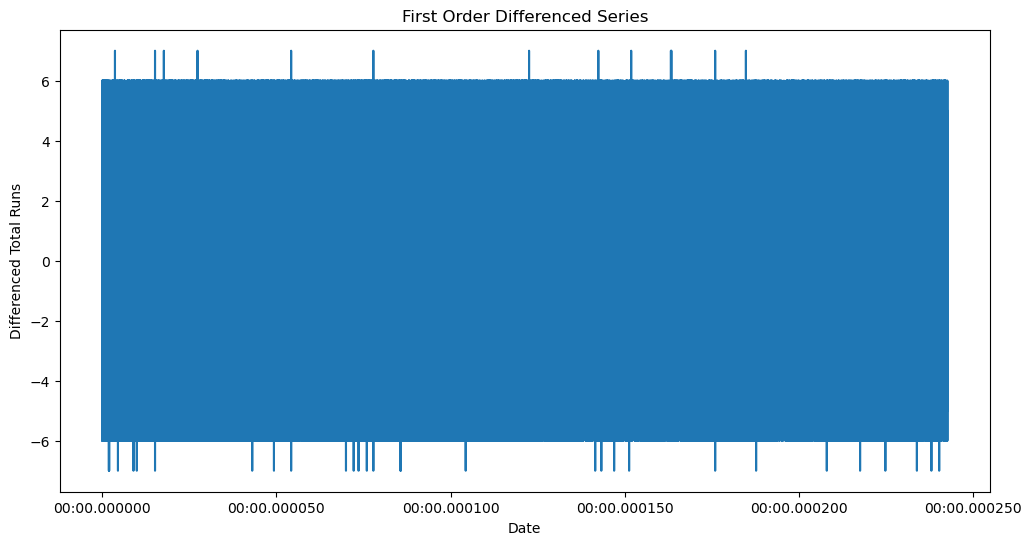

In [50]:
df['Diff_1'] = df['runs'] - df['runs'].shift(1)
plt.figure(figsize=(12, 6))
plt.plot(df['Diff_1'])
plt.title('First Order Differenced Series')
plt.xlabel('Date')
plt.ylabel('Differenced Total Runs')
plt.show()

### ADF Test on Differenced Data

In [53]:
adf_result_diff = adfuller(df ['Diff_1'].dropna())
print('ADF Statistic: %f' % adf_result_diff[0])
print('p-value: %f' % adf_result_diff[1])
print('Critical Values:')
for key, value in adf_result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -89.229394
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


#### Interpretation:
##### If p-value > 0.05, fail to reject H0; the series is stationary.

## Log Transformation

#### Apply Log Transformation

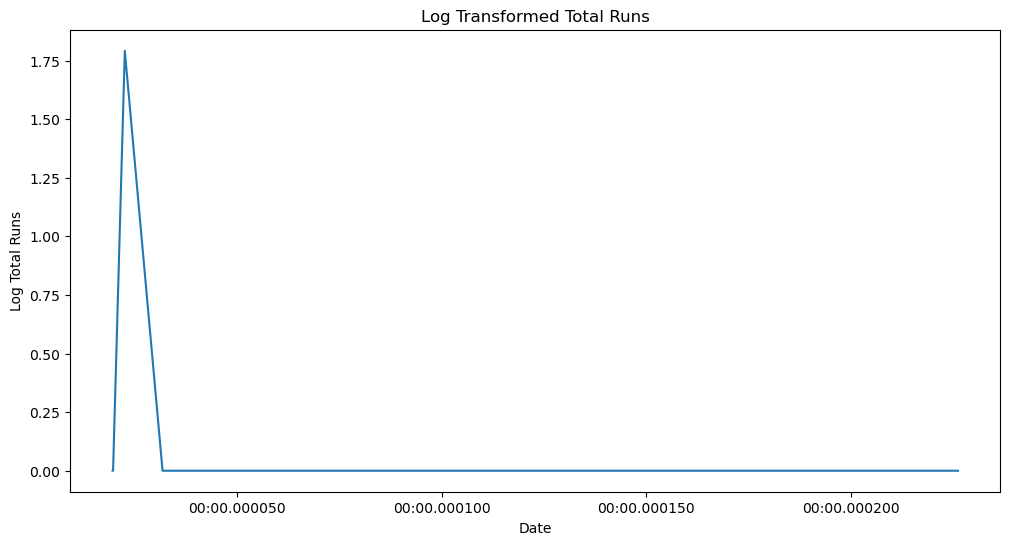

In [66]:
df['Log_Total_Runs'] = np.log(df['runs']).replace([np.inf, -np.inf], np.nan)
df['Log_Diff_1'] = df['Log_Total_Runs'] - df['Log_Total_Runs'].shift(1)
df['Log_Diff_1'].dropna(inplace=True)
df.dropna(inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(df['Log_Total_Runs'])
plt.title('Log Transformed Total Runs')
plt.xlabel('Date')
plt.ylabel('Log Total Runs')
plt.show()


### Dont run - Differencing the Log Transformed Data


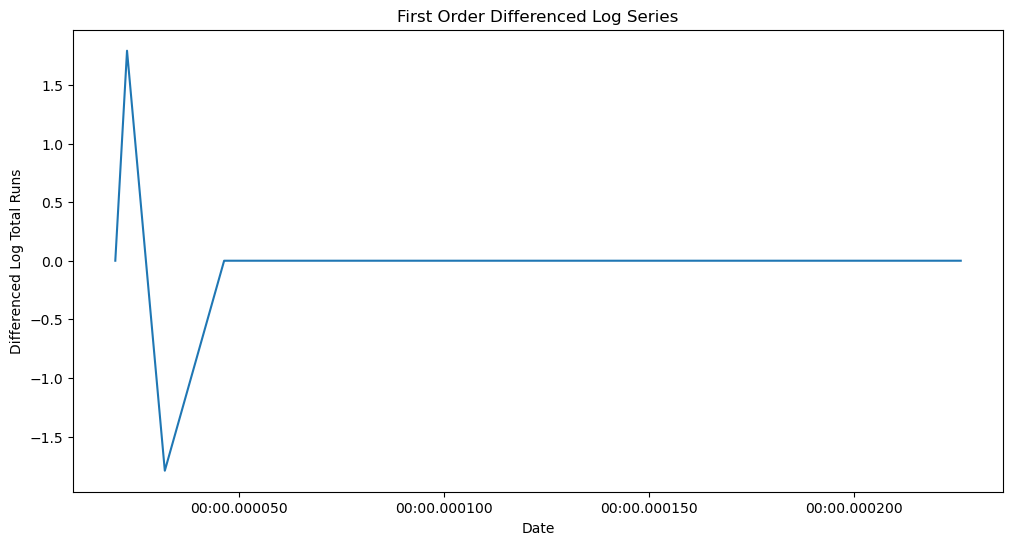

In [68]:
df['Log_Diff_1'] = df['Log_Total_Runs'] - df['Log_Total_Runs'].shift(1)

plt.figure(figsize=(12, 6))
plt.plot(df['Log_Diff_1'])
plt.title('First Order Differenced Log Series')
plt.xlabel('Date')
plt.ylabel('Differenced Log Total Runs')
plt.show()

### ADF Test on Log Differenced Dataa


In [74]:
# Filter out non-positive 'runs' before applying log
df = df[df['runs'] > 0]  # Ensure 'runs' values are positive for log transformation

# Calculate 'Log_Total_Runs'
df['Log_Total_Runs'] = np.log(df['runs']).replace([np.inf, -np.inf], np.nan)
df.dropna(subset=['Log_Total_Runs'], inplace=True)

# Calculate 'Log_Diff_1'
df['Log_Diff_1'] = df['Log_Total_Runs'] - df['Log_Total_Runs'].shift(1)
df.dropna(subset=['Log_Diff_1'], inplace=True)

# Replace infinity or negative infinity with NaN
df['Log_Diff_1'] = df['Log_Diff_1'].replace([np.inf, -np.inf], np.nan)
df.dropna(subset=['Log_Diff_1'], inplace=True)

# Perform ADF test if there is more than one unique value
if df['Log_Diff_1'].nunique() > 1:
    adf_result_log_diff = adfuller(df['Log_Diff_1'])
    print('ADF Statistic: %f' % adf_result_log_diff[0])
    print('p-value: %f' % adf_result_log_diff[1])
    print('Critical Values:')
    for key, value in adf_result_log_diff[4].items():
        print('\t%s: %.3f' % (key, value))


ADF Statistic: -12.000000
p-value: 0.000000
Critical Values:
	1%: -3.924
	5%: -3.068
	10%: -2.674


C:\Users\harik\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


#### Interpretation:
##### If p-value > 0.05, fail to reject H0; the series is now stationary.

### Re-Checking ACF and PACF Plots

#### ACF Plot of Differenced Series

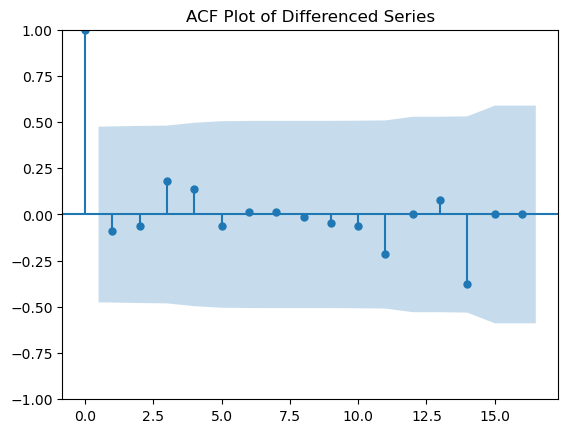

In [80]:
diff_length = len(df['Log_Diff_1'].dropna())
lags = min(50, diff_length - 1)
plot_acf(df['Diff_1'].dropna(), lags=lags)
plt.title('ACF Plot of Differenced Series')
plt.show()

#### PACF Plot of Differenced Series

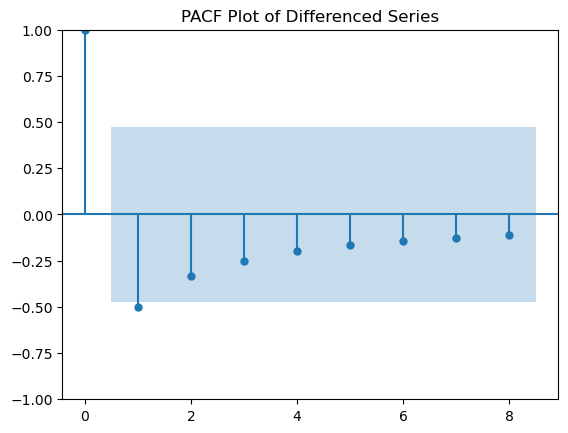

In [83]:
diff_length = len(df['Log_Diff_1'].dropna())
# Set the number of lags to be less than 50% of the series length
max_lags = diff_length // 2  # 50% of the series length
# Ensure the number of lags does not exceed the available length
lags = min(10, max_lags)
# Plot the PACF
plot_pacf(df['Log_Diff_1'].dropna(), lags=lags)
plt.title('PACF Plot of Differenced Series')
plt.show()

#### Observation:
##### Autocorrelation drops off rapidly, indicating stationarity.

## Forecast Using SARIMAX

In [87]:
# Ensure 'season' is the index
virat_season_runs.set_index('season', inplace=True)

In [89]:
# Get the number of seasons
num_seasons = len(virat_season_runs)
num_seasons

16

In [97]:
# Fit the SARIMA model
model = SARIMAX(virat_season_runs,
                order=(1, 1, 1),  # p, d, q - non seasonal parameters
                seasonal_order=(1, 1, 1, 4))  # P, D, Q, m  - seasonal parameters

C:\Users\harik\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\harik\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [99]:
#start_params = [0, 0, 0, 0, 0, 0, 1]
result = model.fit()
result

C:\Users\harik\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\harik\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [101]:
# Forecast for the 2025 season
forecast = result.get_forecast(steps=5)  # Forecast for the next season
forecast_runs = forecast.predicted_mean.astype(int)
print(f"Predicted runs for next season: {forecast_runs}")

Predicted runs for next season: 2024-01-01    599
2025-01-01    556
2026-01-01    502
2027-01-01    683
2028-01-01    699
Freq: YS-JAN, Name: predicted_mean, dtype: int32


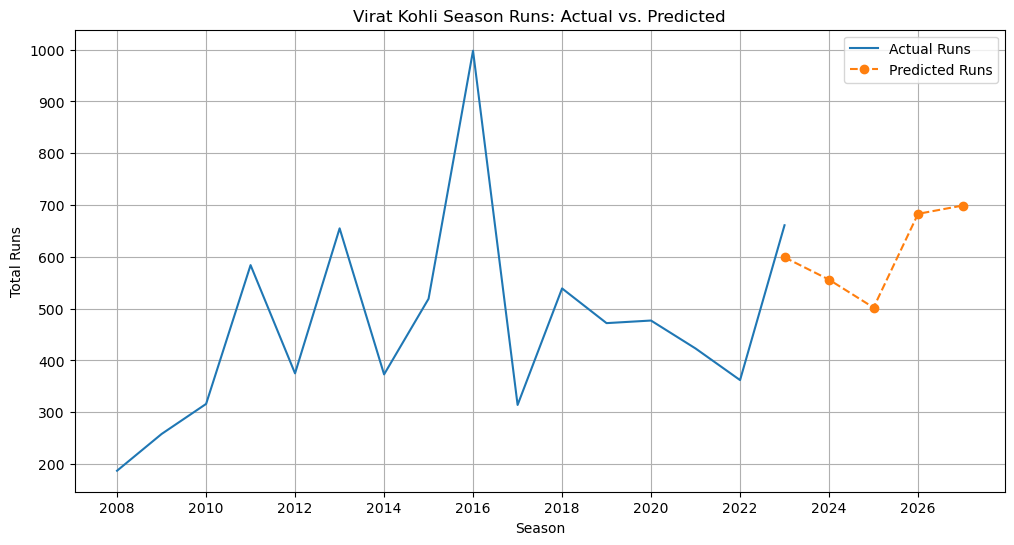

In [103]:
# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'season': pd.date_range(start='2023-01-01', periods=5, freq='YS'), 'predicted_runs': forecast_runs.values})
# Merge the forecast with the original data
merged_data = pd.concat([virat_season_runs.reset_index(), forecast_df], ignore_index = True)
merged_data['season'] = pd.to_datetime(merged_data['season'])
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(virat_season_runs.index, virat_season_runs['runs'], label='Actual Runs')
plt.plot(forecast_df['season'], forecast_df['predicted_runs'], label='Predicted Runs', linestyle='--', marker='o')
plt.title('Virat Kohli Season Runs: Actual vs. Predicted')
plt.xlabel('Season')
plt.ylabel('Total Runs')
plt.legend()
plt.grid(True)
plt.show()

##### It begins by transforming non-stationary IPL data into stationary data to prepare it for modeling.
##### The data generation process involves importing necessary libraries, cleaning the data, normalizing the runs for performance comparison, and filtering specific players' performance by season.
##### Various visualizations are created, including time series plots and histograms, to understand trends and distributions in the data. 
##### Missing values and outliers are handled through preprocessing steps, ensuring that the dataset is ready for modeling. 
##### Feature engineering includes creating lag features to capture previous performance metrics, which may enhance predictive models. 